# FacebookAI/roberta-large Finetuning: banking77 dataset

## Packages

In [12]:
# Load packages
from dotenv import load_dotenv

load_dotenv()
# Dataset
from datasets import load_dataset
# For EDA
from collections import Counter
import matplotlib.pyplot as plt
# For Model training
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer , AdamW , get_linear_schedule_with_warmup
# For Evaluation
import numpy as np
import pandas as pd
import math
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AdamW, 
    get_linear_schedule_with_warmup,
    DataCollatorWithPadding,
    Trainer, 
    TrainingArguments,
    AutoModelForCausalLM
)

from peft import (
    LoraConfig, 
    get_peft_model, 
    TaskType,
)

import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset

In [2]:
# Training info
dataset_id = "PolyAI/banking77"  # Training dataset
model_id = "FacebookAI/roberta-large"  # For tokenize and modeling

# Load everythings for training
dataset = load_dataset(dataset_id)

# Check dataset
print(dataset) # train: 10003 rows | test: 3080 rows

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 10003
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3080
    })
})


## Data Processing

### Tokenization

In [3]:
tokenizer = AutoTokenizer.from_pretrained(model_id)

/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:
# tokenize函數 用來批次將資料轉換成input tokens
def tokenize_function(data):
    return tokenizer(
        data["text"],
        # add_special_tokens=True, # Default = True [CLS], [SEP]
        padding="max_length", # 補值到模型可接受的最大值
        max_length=64, # 設定裁切長度
        return_attention_mask=True,
        truncation=True # 是否裁切(要設定max_length才會裁切)
    )

# Tokenize
tokenized_datasets = dataset.map(tokenize_function, batched=True) # 將dataset轉換為input tokens

### Train-Valid-Test Split

In [5]:
# Train-Valid-Test split
train_test_split = tokenized_datasets["train"].shuffle(seed=666).train_test_split(test_size=0.1, seed=666)
train_dataset, valid_dataset = train_test_split["train"], train_test_split["test"]
# Test dataset remains the same
test_dataset = tokenized_datasets["test"].shuffle(seed=666)

## Model

In [6]:
model = AutoModelForSequenceClassification.from_pretrained(model_id,num_labels=77)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### LoRA

In [7]:
# Define the LoRA Configuration
lora_config = LoraConfig(
    r=8, # Rank Number
    lora_alpha=32, # Alpha (Scaling Factor)
    lora_dropout=0.05, # Dropout Prob for Lora
    target_modules=["query", "key","value"], # Which layer to apply LoRA, usually only apply on MultiHead Attention Layer
    bias='none',
    task_type=TaskType.SEQ_CLS # Seqence to Classification Task
)
# Get our LoRA-enabled model
peft_model = get_peft_model(model, 
                            lora_config)


### Metrics

In [8]:
def compute_metrics(pred):

    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
    }
    

## Test_train

### test7 (lora vs lr)

In [13]:
def test7_training(p_model,lr=2e-5,epoch_num=10):
    train_batch_size = 16
    eval_batch_size = 32

    # Define training Args
    peft_training_args = TrainingArguments(
        output_dir='./result-roberta-lora',
        logging_dir='./logs',
        learning_rate=lr,
        per_device_train_batch_size=train_batch_size, # You can adjust this value base on your available GPU, You may encounter "out of memory" error if this value is too lartge
        per_device_eval_batch_size=eval_batch_size, # You can adjust this value base on your available GPU, You may encounter "out of memory" error if this value is too lartge
        num_train_epochs=epoch_num,
        logging_steps=200,
        # evaluation_strategy='steps', 
        evaluation_strategy="epoch",         # 每個 epoch 評估一次
        save_strategy="epoch", 
        # eval_steps=10,
        weight_decay=0.01,
        fp16=True, # Only use with GPU
        report_to='none',
        save_total_limit=1,
        load_best_model_at_end=True, 
        metric_for_best_model="accuracy",
    )   

    # Define Optimzer
    optimizer = AdamW(p_model.parameters(), 
                    lr=1e-4,
                    no_deprecation_warning=True)

    # Define Scheduler
    n_epochs = peft_training_args.num_train_epochs
    total_steps = n_epochs * math.ceil(len(train_dataset) / train_batch_size / 2)
    lr_scheduler = get_linear_schedule_with_warmup(
        optimizer, 
        num_warmup_steps=0, 
        num_training_steps=total_steps)

    # Data Collator
    collator = DataCollatorWithPadding(
        tokenizer=tokenizer, 
        padding="longest"
    )
    
    
    peft_trainer = Trainer(
        model=p_model,
        args=peft_training_args,
        train_dataset=train_dataset, # Training Data
        eval_dataset=valid_dataset, # Evaluation Data
        compute_metrics=compute_metrics,
        optimizers=(optimizer,lr_scheduler),
        data_collator=collator
    )
    

    peft_trainer.train()
    
    return peft_trainer.evaluate(test_dataset)


result_7 = {}
for l in lr:
    print("-------------------------{}-------------------------".format(l))
    model = AutoModelForSequenceClassification.from_pretrained(model_id,num_labels=77)
    # Define the LoRA Configuration
    lora_config = LoraConfig(
        r=8, # Rank Number
        lora_alpha=32, # Alpha (Scaling Factor)
        lora_dropout=0.05, # Dropout Prob for Lora
        target_modules=["query", "key","value"], # Which layer to apply LoRA, usually only apply on MultiHead Attention Layer
        bias='none',
        task_type=TaskType.SEQ_CLS # Seqence to Classification Task
    )
    # Get our LoRA-enabled model
    peft_model = get_peft_model(model, 
                                lora_config)

    result_7[l] = test7_training(peft_model,lr=l)

-------------------------5e-06-------------------------


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.401900,0.630483,0.853147,0.851844,0.871384,0.853147
2,0.510200,0.361785,0.894106,0.895770,0.907036,0.894106
3,0.347700,0.309491,0.915085,0.916592,0.924549,0.915085
4,0.270300,0.287333,0.919081,0.920018,0.925458,0.919081
5,0.237800,0.277974,0.922078,0.923208,0.928232,0.922078
6,0.211600,0.277926,0.922078,0.923208,0.928232,0.922078
7,0.221900,0.277926,0.922078,0.923208,0.928232,0.922078
8,0.219100,0.277926,0.922078,0.923208,0.928232,0.922078
9,0.224800,0.277926,0.922078,0.923208,0.928232,0.922078
10,0.235400,0.277926,0.922078,0.923208,0.928232,0.922078


/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


-------------------------1e-05-------------------------


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.537200,0.674998,0.832168,0.830109,0.857670,0.832168
2,0.506800,0.360243,0.902098,0.902184,0.912192,0.902098
3,0.339800,0.313426,0.918082,0.919087,0.926490,0.918082
4,0.271300,0.289331,0.917083,0.917904,0.922760,0.917083
5,0.234700,0.280711,0.922078,0.923030,0.927541,0.922078
6,0.209200,0.280716,0.922078,0.923030,0.927541,0.922078
7,0.220100,0.280716,0.922078,0.923030,0.927541,0.922078
8,0.217900,0.280716,0.922078,0.923030,0.927541,0.922078
9,0.219100,0.280716,0.922078,0.923030,0.927541,0.922078
10,0.231900,0.280716,0.922078,0.923030,0.927541,0.922078


/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


-------------------------2e-05-------------------------


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.537200,0.674998,0.832168,0.830109,0.857670,0.832168
2,0.506800,0.360243,0.902098,0.902184,0.912192,0.902098
3,0.339800,0.313426,0.918082,0.919087,0.926490,0.918082
4,0.271300,0.289331,0.917083,0.917904,0.922760,0.917083
5,0.234700,0.280711,0.922078,0.923030,0.927541,0.922078
6,0.209200,0.280716,0.922078,0.923030,0.927541,0.922078
7,0.220100,0.280716,0.922078,0.923030,0.927541,0.922078
8,0.217900,0.280716,0.922078,0.923030,0.927541,0.922078
9,0.219100,0.280716,0.922078,0.923030,0.927541,0.922078
10,0.231900,0.280716,0.922078,0.923030,0.927541,0.922078


/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


-------------------------5e-05-------------------------


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.537200,0.674998,0.832168,0.830109,0.857670,0.832168
2,0.506800,0.360243,0.902098,0.902184,0.912192,0.902098
3,0.339800,0.313426,0.918082,0.919087,0.926490,0.918082
4,0.271300,0.289331,0.917083,0.917904,0.922760,0.917083
5,0.234700,0.280711,0.922078,0.923030,0.927541,0.922078
6,0.209200,0.280716,0.922078,0.923030,0.927541,0.922078
7,0.220100,0.280716,0.922078,0.923030,0.927541,0.922078
8,0.217900,0.280716,0.922078,0.923030,0.927541,0.922078
9,0.219100,0.280716,0.922078,0.923030,0.927541,0.922078
10,0.231900,0.280716,0.922078,0.923030,0.927541,0.922078


/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


-------------------------0.0001-------------------------


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.537200,0.674998,0.832168,0.830109,0.857670,0.832168
2,0.506800,0.360243,0.902098,0.902184,0.912192,0.902098
3,0.339800,0.313426,0.918082,0.919087,0.926490,0.918082
4,0.271300,0.289331,0.917083,0.917904,0.922760,0.917083
5,0.234700,0.280711,0.922078,0.923030,0.927541,0.922078
6,0.209200,0.280716,0.922078,0.923030,0.927541,0.922078
7,0.220100,0.280716,0.922078,0.923030,0.927541,0.922078
8,0.217900,0.280716,0.922078,0.923030,0.927541,0.922078
9,0.219100,0.280716,0.922078,0.923030,0.927541,0.922078
10,0.231900,0.280716,0.922078,0.923030,0.927541,0.922078


/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [14]:
result_7

{5e-06: {'eval_loss': 0.25773265957832336,
  'eval_accuracy': 0.9272727272727272,
  'eval_f1': 0.9272369802062309,
  'eval_precision': 0.9302659558045057,
  'eval_recall': 0.9272727272727272,
  'eval_runtime': 3.4672,
  'eval_samples_per_second': 888.324,
  'eval_steps_per_second': 27.976,
  'epoch': 10.0},
 1e-05: {'eval_loss': 0.25526678562164307,
  'eval_accuracy': 0.9262987012987013,
  'eval_f1': 0.9264716946785295,
  'eval_precision': 0.9291673042358588,
  'eval_recall': 0.9262987012987013,
  'eval_runtime': 3.4701,
  'eval_samples_per_second': 887.591,
  'eval_steps_per_second': 27.953,
  'epoch': 10.0},
 2e-05: {'eval_loss': 0.25526678562164307,
  'eval_accuracy': 0.9262987012987013,
  'eval_f1': 0.9264716946785295,
  'eval_precision': 0.9291673042358588,
  'eval_recall': 0.9262987012987013,
  'eval_runtime': 3.4774,
  'eval_samples_per_second': 885.717,
  'eval_steps_per_second': 27.894,
  'epoch': 10.0},
 5e-05: {'eval_loss': 0.25526678562164307,
  'eval_accuracy': 0.926298701

### test8 (no lora vs lr)

In [15]:
def test8_training(p_model,lr=2e-5,epoch_num=10):
    train_batch_size = 16
    eval_batch_size = 32

    # Define training Args
    peft_training_args = TrainingArguments(
        output_dir='./result-roberta-lora',
        logging_dir='./logs',
        learning_rate=lr,
        per_device_train_batch_size=train_batch_size, # You can adjust this value base on your available GPU, You may encounter "out of memory" error if this value is too lartge
        per_device_eval_batch_size=eval_batch_size, # You can adjust this value base on your available GPU, You may encounter "out of memory" error if this value is too lartge
        num_train_epochs=epoch_num,
        logging_steps=200,
        # evaluation_strategy='steps', 
        evaluation_strategy="epoch",         # 每個 epoch 評估一次
        save_strategy="epoch", 
        # eval_steps=10,
        weight_decay=0.01,
        # fp16=True, # Only use with GPU
        report_to='none',
        save_total_limit=1,
        load_best_model_at_end=True, 
        metric_for_best_model="accuracy",
    )   

    # # Define Optimzer
    # optimizer = AdamW(p_model.parameters(), 
    #                 lr=1e-4,
    #                 no_deprecation_warning=True)

    # # Define Scheduler
    # n_epochs = peft_training_args.num_train_epochs
    # total_steps = n_epochs * math.ceil(len(train_dataset) / train_batch_size / 2)
    # lr_scheduler = get_linear_schedule_with_warmup(
    #     optimizer, 
    #     num_warmup_steps=0, 
    #     num_training_steps=total_steps)

    # # Data Collator
    # collator = DataCollatorWithPadding(
    #     tokenizer=tokenizer, 
    #     padding="longest"
    # )
    
    
    peft_trainer = Trainer(
        model=p_model,
        args=peft_training_args,
        train_dataset=train_dataset, # Training Data
        eval_dataset=valid_dataset, # Evaluation Data
        compute_metrics=compute_metrics,
        # optimizers=(optimizer,lr_scheduler),
        # data_collator=collator
    )
    

    peft_trainer.train()
    
    return peft_trainer.evaluate(test_dataset)


result_8 = {}
for l in lr:
    print("-------------------------{}-------------------------".format(l))
    model = AutoModelForSequenceClassification.from_pretrained(model_id,num_labels=77)
    # # Define the LoRA Configuration
    # lora_config = LoraConfig(
    #     r=8, # Rank Number
    #     lora_alpha=32, # Alpha (Scaling Factor)
    #     lora_dropout=0.05, # Dropout Prob for Lora
    #     target_modules=["query", "key","value"], # Which layer to apply LoRA, usually only apply on MultiHead Attention Layer
    #     bias='none',
    #     task_type=TaskType.SEQ_CLS # Seqence to Classification Task
    # )
    # # Get our LoRA-enabled model
    # peft_model = get_peft_model(model, 
    #                             lora_config)

    result_8[l] = test8_training(model,lr=l)

-------------------------5e-06-------------------------


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,3.825800,2.049011,0.707293,0.683999,0.757796,0.707293
2,1.391200,0.732023,0.865135,0.860000,0.887043,0.865135
3,0.634700,0.436830,0.898102,0.899901,0.915351,0.898102
4,0.380600,0.348232,0.913087,0.914334,0.923076,0.913087
5,0.258400,0.321090,0.924076,0.924883,0.931471,0.924076
6,0.192200,0.301928,0.924076,0.924950,0.931943,0.924076
7,0.151900,0.324243,0.929071,0.930143,0.936367,0.929071
8,0.124400,0.315056,0.932068,0.933145,0.938894,0.932068
9,0.101600,0.315584,0.934066,0.935232,0.940444,0.934066
10,0.109000,0.315092,0.935065,0.936248,0.941487,0.935065


/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


-------------------------1e-05-------------------------


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.380700,0.773682,0.858142,0.856383,0.876710,0.858142
2,0.523300,0.360910,0.911089,0.911512,0.923305,0.911089
3,0.269800,0.322510,0.924076,0.925397,0.935423,0.924076
4,0.170700,0.306707,0.934066,0.935169,0.941750,0.934066
5,0.120700,0.345417,0.931069,0.931337,0.936288,0.931069
6,0.072400,0.386133,0.926074,0.926684,0.934232,0.926074
7,0.051800,0.381702,0.933067,0.934235,0.941584,0.933067
8,0.049700,0.372725,0.936064,0.936889,0.943142,0.936064
9,0.036300,0.379339,0.937063,0.937875,0.942791,0.937063
10,0.029200,0.371425,0.938062,0.938699,0.942758,0.938062


/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


-------------------------2e-05-------------------------


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.506500,0.638161,0.835165,0.833890,0.863020,0.835165
2,0.454300,0.389069,0.901099,0.901367,0.915062,0.901099
3,0.244700,0.374776,0.917083,0.919007,0.928415,0.917083
4,0.170500,0.345531,0.933067,0.933770,0.940735,0.933067
5,0.123600,0.382221,0.933067,0.934016,0.939700,0.933067
6,0.060900,0.416538,0.925075,0.926101,0.935227,0.925075
7,0.045700,0.411555,0.935065,0.935770,0.941924,0.935065
8,0.037900,0.396498,0.939061,0.939713,0.943992,0.939061
9,0.022200,0.414426,0.941059,0.942073,0.947064,0.941059
10,0.017700,0.414125,0.938062,0.939068,0.944517,0.938062


/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


-------------------------5e-05-------------------------


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,4.347200,4.306715,0.025974,0.001315,0.000675,0.025974
2,4.333100,4.308145,0.015984,0.000503,0.000255,0.015984
3,4.336500,4.313230,0.015984,0.000503,0.000255,0.015984
4,4.357300,4.312174,0.017982,0.000635,0.000323,0.017982
5,4.331300,4.306882,0.018981,0.000707,0.000360,0.018981
6,4.336300,4.520001,0.013986,0.000386,0.000196,0.013986
7,4.325500,4.315813,0.022977,0.001032,0.000528,0.022977
8,4.316000,4.317815,0.015984,0.000503,0.000255,0.015984
9,4.300500,4.314338,0.015984,0.000503,0.000255,0.015984
10,4.295400,4.314927,0.015984,0.000503,0.000255,0.015984


/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


-------------------------0.0001-------------------------


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,4.366900,4.318172,0.025974,0.001315,0.000675,0.025974
2,4.359100,4.307054,0.022977,0.001032,0.000528,0.022977
3,4.356300,4.316004,0.020979,0.000862,0.000440,0.020979
4,4.353900,4.311728,0.017982,0.000635,0.000323,0.017982
5,4.327500,4.310053,0.018981,0.000707,0.000360,0.018981
6,4.341100,4.309669,0.015984,0.000503,0.000255,0.015984
7,4.334400,4.320176,0.022977,0.001032,0.000528,0.022977
8,4.318400,4.322350,0.015984,0.000503,0.000255,0.015984
9,4.307600,4.321674,0.015984,0.000503,0.000255,0.015984
10,4.296200,4.324461,0.015984,0.000503,0.000255,0.015984


/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [16]:
result_8

{5e-06: {'eval_loss': 0.30951035022735596,
  'eval_accuracy': 0.9324675324675324,
  'eval_f1': 0.9322610623749021,
  'eval_precision': 0.9343288892271031,
  'eval_recall': 0.9324675324675324,
  'eval_runtime': 2.9436,
  'eval_samples_per_second': 1046.325,
  'eval_steps_per_second': 32.952,
  'epoch': 10.0},
 1e-05: {'eval_loss': 0.3918149471282959,
  'eval_accuracy': 0.9366883116883117,
  'eval_f1': 0.9366320283753556,
  'eval_precision': 0.9380176965925046,
  'eval_recall': 0.9366883116883117,
  'eval_runtime': 2.9334,
  'eval_samples_per_second': 1049.961,
  'eval_steps_per_second': 33.067,
  'epoch': 10.0},
 2e-05: {'eval_loss': 0.39998525381088257,
  'eval_accuracy': 0.9373376623376624,
  'eval_f1': 0.9372628931567029,
  'eval_precision': 0.9387421046738013,
  'eval_recall': 0.9373376623376624,
  'eval_runtime': 2.9406,
  'eval_samples_per_second': 1047.42,
  'eval_steps_per_second': 32.987,
  'epoch': 10.0},
 5e-05: {'eval_loss': 4.390336513519287,
  'eval_accuracy': 0.0129870129

### test9 (lora + stratify_col)

In [35]:
def test9_training(p_model,lr=1e-5,epoch_num=10):
    train_batch_size = 16
    eval_batch_size = 32

    # Define training Args
    training_args = TrainingArguments(
        output_dir='./result-roberta-lora',
        logging_dir='./logs',
        learning_rate=lr,
        per_device_train_batch_size=train_batch_size, # You can adjust this value base on your available GPU, You may encounter "out of memory" error if this value is too lartge
        per_device_eval_batch_size=eval_batch_size, # You can adjust this value base on your available GPU, You may encounter "out of memory" error if this value is too lartge
        num_train_epochs=epoch_num,
        logging_steps=200,
        # evaluation_strategy='steps', 
        evaluation_strategy="epoch",         # 每個 epoch 評估一次
        save_strategy="epoch", 
        # eval_steps=10,
        weight_decay=0.01,
        # fp16=True, # Only use with GPU
        report_to='none',
        save_total_limit=1,
        load_best_model_at_end=True, 
        metric_for_best_model="accuracy",
    )   
    
    
    train_test_split = tokenized_datasets["train"].shuffle(seed=666).train_test_split(
        test_size=0.1,  # 9:1 切分比例
        stratify_by_column='label',  # 確保每個類別的比例保持不變
        seed=666  # 設置隨機種子以便重現結果
        )
    train_dataset, valid_dataset = train_test_split["train"], train_test_split["test"]
    test_dataset = tokenized_datasets["test"].shuffle(seed=666)
    
    
    
    trainer = Trainer(
        model=p_model,
        args=training_args,
        train_dataset=train_dataset, # Training Data
        eval_dataset=valid_dataset, # Evaluation Data
        compute_metrics=compute_metrics,
    )

    trainer.train()
    
    return trainer.evaluate(test_dataset)


result_9 = {}
model = AutoModelForSequenceClassification.from_pretrained(model_id,num_labels=77)
# Define the LoRA Configuration
lora_config = LoraConfig(
    r=8, # Rank Number
    lora_alpha=32, # Alpha (Scaling Factor)
    lora_dropout=0.05, # Dropout Prob for Lora
    target_modules=["query", "key","value"], # Which layer to apply LoRA, usually only apply on MultiHead Attention Layer
    bias='none',
    task_type=TaskType.SEQ_CLS # Seqence to Classification Task
)
# Get our LoRA-enabled model
peft_model = get_peft_model(model, 
                            lora_config)
result_9["test"] = test9_training(peft_model)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.345800,0.628815,0.896104,0.892462,0.905989,0.896104
2,0.473000,0.307110,0.924076,0.923394,0.931843,0.924076
3,0.245000,0.247149,0.938062,0.937660,0.942212,0.938062
4,0.153900,0.261734,0.943057,0.942767,0.948284,0.943057
5,0.114400,0.282553,0.940060,0.939600,0.944531,0.940060
6,0.086000,0.301544,0.945055,0.944911,0.950045,0.945055
7,0.053500,0.315876,0.942058,0.941921,0.946971,0.942058
8,0.033100,0.324361,0.945055,0.944994,0.949675,0.945055
9,0.030400,0.339848,0.946054,0.945880,0.950179,0.946054
10,0.017900,0.337447,0.946054,0.946060,0.950576,0.946054


In [36]:
result_9

{'test': {'eval_loss': 0.3648012578487396,
  'eval_accuracy': 0.939935064935065,
  'eval_f1': 0.9398834587189276,
  'eval_precision': 0.9421382933170157,
  'eval_recall': 0.939935064935065,
  'eval_runtime': 2.9432,
  'eval_samples_per_second': 1046.488,
  'eval_steps_per_second': 32.958,
  'epoch': 10.0}}

### test10 (lora vs lr + test_size=0.15 + stratify_col)

In [42]:
def test10_training(p_model,lr=5e-5,epoch_num=10):
    train_batch_size = 16
    eval_batch_size = 32

    # Define training Args
    training_args = TrainingArguments(
        output_dir='./result-roberta-lora',
        logging_dir='./logs',
        learning_rate=lr,
        per_device_train_batch_size=train_batch_size, # You can adjust this value base on your available GPU, You may encounter "out of memory" error if this value is too lartge
        per_device_eval_batch_size=eval_batch_size, # You can adjust this value base on your available GPU, You may encounter "out of memory" error if this value is too lartge
        num_train_epochs=epoch_num,
        logging_steps=200,
        # evaluation_strategy='steps', 
        evaluation_strategy="epoch",         # 每個 epoch 評估一次
        save_strategy="epoch", 
        # eval_steps=10,
        weight_decay=0.01,
        # fp16=True, # Only use with GPU
        report_to='none',
        save_total_limit=1,
        load_best_model_at_end=True, 
        metric_for_best_model="accuracy",
    )   
    
    
    train_test_split = tokenized_datasets["train"].shuffle(seed=666).train_test_split(
        test_size=0.15,  # 9:1 切分比例
        stratify_by_column='label',  # 確保每個類別的比例保持不變
        seed=666  # 設置隨機種子以便重現結果
        )
    train_dataset, valid_dataset = train_test_split["train"], train_test_split["test"]
    test_dataset = tokenized_datasets["test"].shuffle(seed=666)
    
    
    
    trainer = Trainer(
        model=p_model,
        args=training_args,
        train_dataset=train_dataset, # Training Data
        eval_dataset=valid_dataset, # Evaluation Data
        compute_metrics=compute_metrics,
    )

    trainer.train()
    
    return trainer.evaluate(test_dataset)


result_10 = {}
model = AutoModelForSequenceClassification.from_pretrained(model_id,num_labels=77)
# Define the LoRA Configuration
lora_config = LoraConfig(
    r=8, # Rank Number
    lora_alpha=32, # Alpha (Scaling Factor)
    lora_dropout=0.05, # Dropout Prob for Lora
    target_modules=["query", "key","value"], # Which layer to apply LoRA, usually only apply on MultiHead Attention Layer
    bias='none',
    task_type=TaskType.SEQ_CLS # Seqence to Classification Task
)
# Get our LoRA-enabled model
peft_model = get_peft_model(model, 
                            lora_config)
result_10["test"] = test10_training(peft_model)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,3.505500,1.410881,0.728847,0.709481,0.752191,0.728847
2,0.829300,0.548082,0.875416,0.871708,0.883025,0.875416
3,0.563100,0.390660,0.893404,0.891614,0.899386,0.893404
4,0.382700,0.328071,0.909394,0.907911,0.913733,0.909394
5,0.319800,0.297226,0.914724,0.914467,0.920168,0.914724
6,0.295500,0.275959,0.923384,0.922878,0.927176,0.923384
7,0.265300,0.267128,0.924051,0.923492,0.927467,0.924051
8,0.239000,0.260522,0.924717,0.924442,0.928669,0.924717
9,0.224200,0.258065,0.928048,0.927703,0.931332,0.928048
10,0.208000,0.254049,0.926716,0.926304,0.929706,0.926716


/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [43]:
model = AutoModelForSequenceClassification.from_pretrained(model_id,num_labels=77)
# Define the LoRA Configuration
lora_config = LoraConfig(
    r=8, # Rank Number
    lora_alpha=32, # Alpha (Scaling Factor)
    lora_dropout=0.05, # Dropout Prob for Lora
    target_modules=["query", "key","value"], # Which layer to apply LoRA, usually only apply on MultiHead Attention Layer
    bias='none',
    task_type=TaskType.SEQ_CLS # Seqence to Classification Task
)
# Get our LoRA-enabled model
peft_model = get_peft_model(model, 
                            lora_config)
result_10["test2e-05"] = test10_training(peft_model,lr=2e-05)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,4.282900,4.065140,0.090606,0.067016,0.129469,0.090606
2,2.969800,2.128684,0.610260,0.566796,0.643723,0.610260
3,1.976300,1.241181,0.782811,0.761395,0.784710,0.782811
4,1.224000,0.865004,0.834111,0.822162,0.831620,0.834111
5,0.905500,0.681992,0.860759,0.856734,0.871899,0.860759
6,0.789000,0.578731,0.874084,0.871394,0.880441,0.874084
7,0.677400,0.521802,0.881412,0.879485,0.888066,0.881412
8,0.617100,0.486475,0.886742,0.884849,0.893413,0.886742
9,0.579200,0.468839,0.887408,0.885498,0.893974,0.887408
10,0.540400,0.463068,0.888741,0.887011,0.895933,0.888741


/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [44]:
model = AutoModelForSequenceClassification.from_pretrained(model_id,num_labels=77)
# Define the LoRA Configuration
lora_config = LoraConfig(
    r=8, # Rank Number
    lora_alpha=32, # Alpha (Scaling Factor)
    lora_dropout=0.05, # Dropout Prob for Lora
    target_modules=["query", "key","value"], # Which layer to apply LoRA, usually only apply on MultiHead Attention Layer
    bias='none',
    task_type=TaskType.SEQ_CLS # Seqence to Classification Task
)
# Get our LoRA-enabled model
peft_model = get_peft_model(model, 
                            lora_config)
result_10["test1e-05"] = test10_training(peft_model,lr=1e-05)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,4.325300,4.251780,0.022652,0.004336,0.019664,0.022652
2,4.193300,4.043581,0.089940,0.063923,0.096038,0.089940
3,3.914500,3.215606,0.427049,0.362239,0.421455,0.427049
4,3.064000,2.444377,0.565623,0.515824,0.604444,0.565623
5,2.436100,1.970063,0.670886,0.638121,0.681116,0.670886
6,2.150500,1.662053,0.719520,0.688484,0.713391,0.719520
7,1.838700,1.472257,0.752831,0.728466,0.763432,0.752831
8,1.667100,1.343918,0.778148,0.757531,0.789917,0.778148
9,1.580900,1.277138,0.786143,0.766704,0.791376,0.786143
10,1.497500,1.256227,0.789474,0.770453,0.793988,0.789474


/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [46]:
model = AutoModelForSequenceClassification.from_pretrained(model_id,num_labels=77)
# Define the LoRA Configuration
lora_config = LoraConfig(
    r=8, # Rank Number
    lora_alpha=32, # Alpha (Scaling Factor)
    lora_dropout=0.05, # Dropout Prob for Lora
    target_modules=["query", "key","value"], # Which layer to apply LoRA, usually only apply on MultiHead Attention Layer
    bias='none',
    task_type=TaskType.SEQ_CLS # Seqence to Classification Task
)
# Get our LoRA-enabled model
peft_model = get_peft_model(model, 
                            lora_config)
result_10["test1e-04"] = test10_training(peft_model,lr=1e-04)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.908800,0.736109,0.828115,0.819141,0.834563,0.828115
2,0.481400,0.369703,0.902732,0.901722,0.907653,0.902732
3,0.369300,0.305918,0.909394,0.908398,0.915641,0.909394
4,0.265400,0.268718,0.922052,0.921128,0.925551,0.922052
5,0.222700,0.257210,0.919387,0.918914,0.924411,0.919387
6,0.198300,0.238908,0.932045,0.931716,0.936112,0.932045
7,0.172300,0.237131,0.929380,0.928743,0.932686,0.929380
8,0.146900,0.230603,0.932712,0.932519,0.936277,0.932712
9,0.131500,0.233400,0.932045,0.931806,0.935602,0.932045
10,0.118700,0.230374,0.933378,0.933226,0.936769,0.933378


/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [47]:
result_10

{'test': {'eval_loss': 0.2581220269203186,
  'eval_accuracy': 0.9298701298701298,
  'eval_f1': 0.9298981867108761,
  'eval_precision': 0.9328444817384822,
  'eval_recall': 0.9298701298701298,
  'eval_runtime': 3.4929,
  'eval_samples_per_second': 881.79,
  'eval_steps_per_second': 27.771,
  'epoch': 10.0},
 'test2e-05': {'eval_loss': 0.47345271706581116,
  'eval_accuracy': 0.8925324675324675,
  'eval_f1': 0.8921248537179961,
  'eval_precision': 0.898332200417013,
  'eval_recall': 0.8925324675324675,
  'eval_runtime': 3.4881,
  'eval_samples_per_second': 882.992,
  'eval_steps_per_second': 27.809,
  'epoch': 10.0},
 'test1e-05': {'eval_loss': 1.3455982208251953,
  'eval_accuracy': 0.7535714285714286,
  'eval_f1': 0.7334737040588056,
  'eval_precision': 0.7791615845857841,
  'eval_recall': 0.7535714285714286,
  'eval_runtime': 3.4868,
  'eval_samples_per_second': 883.334,
  'eval_steps_per_second': 27.819,
  'epoch': 10.0},
 'test1e-04': {'eval_loss': 0.2363172471523285,
  'eval_accuracy

## Hyperparameter grid search

In [9]:
labels_to_check = [23, 72, 10, 18]

def check_label_proportions(original_dataset, train_dataset, labels_to_check):
    # Extract labels from the original and training datasets
    original_labels = original_dataset['label']
    train_labels = train_dataset['label']
    
    # Count the number of occurrences of each label in the original and training datasets
    original_label_counter = Counter(original_labels)
    train_label_counter = Counter(train_labels)

    # Calculate and print the proportion of each label in the training data
    for label in labels_to_check:
        original_count = original_label_counter[label]
        train_count = train_label_counter[label]
        proportion = train_count / original_count if original_count > 0 else 0
        print(f"Label {label}: {train_count}/{original_count} = {proportion:.2f}")


In [41]:
def test_training(lr=1e-5, epoch_num=10, test_size=0.1, train_batch_size=16):
    # Define training Args
    training_args = TrainingArguments(
        output_dir='./result-roberta-lora',
        logging_dir='./logs',
        learning_rate=lr,
        per_device_train_batch_size=train_batch_size,
        per_device_eval_batch_size=32,
        num_train_epochs=epoch_num,
        
        warmup_steps=500,
        evaluation_strategy="epoch",
        save_strategy="epoch", 
        logging_steps=200,
        weight_decay=0.01,
        load_best_model_at_end=True, 
        metric_for_best_model="accuracy",
        save_total_limit=3,
    )   

    train_test_split = tokenized_datasets["train"].shuffle(seed=777).train_test_split(
        test_size=test_size,  
        # stratify_by_column='label',  
        seed=777  
    )
    train_dataset, valid_dataset = train_test_split["train"], train_test_split["test"]
    test_dataset = tokenized_datasets["test"].shuffle(seed=777)
    
    check_label_proportions(tokenized_datasets["train"], train_dataset, labels_to_check)
    
    ps_model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=77)

    # Define the LoRA Configuration
    lora_config = LoraConfig(
        r=8, 
        lora_alpha=32, 
        lora_dropout=0.05, 
        target_modules=["query", "key", "value"], 
        bias='none',
        task_type=TaskType.SEQ_CLS 
    )

    # Get our LoRA-enabled model
    peft_model = get_peft_model(ps_model, lora_config)

    # 計算參數總數和可訓練參數數量
    total_params = sum(p.numel() for p in peft_model.parameters())
    trainable_params = sum(p.numel() for p in peft_model.parameters() if p.requires_grad)

    print(f"Total parameters: {total_params}")
    print(f"Trainable parameters: {trainable_params}")

    trainer = Trainer(
        model=peft_model,
        args=training_args,
        train_dataset=train_dataset,  
        eval_dataset=valid_dataset,  
        compute_metrics=compute_metrics,
    )

    trainer.train()
    
    return trainer.evaluate(test_dataset)

In [42]:
test_sizes = [0.1,0.15]
learning_rates = [5e-05, 2e-05, 1e-05]
train_batch_sizes = [16,32]
epoch_nums = [10]

In [43]:
result_ans = {}
for q in test_sizes:
    for w in learning_rates:
        for e in train_batch_sizes:
            for r in epoch_nums:
                print("--------------------------{}_{}_{}_{}".format(w,r,e,q))
                result_ans["{}_{}_{}_{}".format(w,r,e,q)] = test_training(lr=w,epoch_num=r,test_size=q,train_batch_size=e)

--------------------------5e-05_10_16_0.1
Label 23: 31/35 = 0.89
Label 72: 37/41 = 0.90
Label 10: 54/59 = 0.92
Label 18: 54/61 = 0.89


/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Total parameters: 357746842
Trainable parameters: 2308173


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,3.497800,1.332923,0.725275,0.694536
2,0.842300,0.532135,0.875125,0.874990
3,0.504800,0.379627,0.908092,0.908848
4,0.381800,0.316785,0.913087,0.913373
5,0.323300,0.292405,0.919081,0.919188
6,0.271500,0.275403,0.925075,0.925090
7,0.249100,0.267347,0.925075,0.925120
8,0.234600,0.264701,0.929071,0.929051
9,0.226500,0.264569,0.929071,0.929112
10,0.215300,0.262105,0.930070,0.930211


--------------------------5e-05_10_32_0.1
Label 23: 31/35 = 0.89
Label 72: 37/41 = 0.90
Label 10: 54/59 = 0.92
Label 18: 54/61 = 0.89


/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Total parameters: 357746842
Trainable parameters: 2308173


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,4.275300,2.896260,0.388611,0.323401
2,2.985300,0.919728,0.809191,0.798016
3,0.881300,0.543158,0.885115,0.884884
4,0.640300,0.415885,0.903097,0.902261
5,0.469000,0.359116,0.908092,0.908452
6,0.418400,0.334177,0.920080,0.920625
7,0.388800,0.315768,0.922078,0.922297
8,0.338900,0.307235,0.921079,0.921495
9,0.322500,0.299405,0.921079,0.921584
10,0.310600,0.297021,0.922078,0.922563


--------------------------2e-05_10_16_0.1
Label 23: 31/35 = 0.89
Label 72: 37/41 = 0.90
Label 10: 54/59 = 0.92
Label 18: 54/61 = 0.89


/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Total parameters: 357746842
Trainable parameters: 2308173


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,4.271600,3.993246,0.113886,0.073773
2,2.957400,2.007927,0.654346,0.616032
3,1.622200,1.142344,0.792208,0.776250
4,1.083300,0.789929,0.842158,0.834944
5,0.833000,0.621162,0.869131,0.867909
6,0.728600,0.534593,0.888112,0.887781
7,0.621100,0.480972,0.892108,0.891550
8,0.576400,0.452744,0.893107,0.892833
9,0.540000,0.436160,0.896104,0.896263
10,0.526800,0.431266,0.898102,0.898155


--------------------------2e-05_10_32_0.1
Label 23: 31/35 = 0.89
Label 72: 37/41 = 0.90
Label 10: 54/59 = 0.92
Label 18: 54/61 = 0.89


/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Total parameters: 357746842
Trainable parameters: 2308173


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,4.329600,4.256037,0.032967,0.009432
2,4.231400,3.362554,0.378621,0.311162
3,2.962900,2.092530,0.640360,0.599457
4,2.262600,1.462225,0.746254,0.720682
5,1.518200,1.125624,0.805195,0.793739
6,1.308700,0.934624,0.828172,0.821483
7,1.171200,0.820408,0.848152,0.842629
8,0.997000,0.752253,0.854146,0.849469
9,0.938900,0.714896,0.863137,0.859445
10,0.891300,0.702499,0.864136,0.860337


--------------------------1e-05_10_16_0.1
Label 23: 31/35 = 0.89
Label 72: 37/41 = 0.90
Label 10: 54/59 = 0.92
Label 18: 54/61 = 0.89


/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Total parameters: 357746842
Trainable parameters: 2308173


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,4.313200,4.277100,0.031968,0.005401
2,4.185600,3.979763,0.150849,0.112715
3,3.574400,3.001811,0.459540,0.404473
4,2.737200,2.274203,0.604396,0.555942
5,2.204600,1.817155,0.685315,0.645402
6,1.937000,1.526073,0.727273,0.698454
7,1.679500,1.343125,0.758242,0.737591
8,1.523900,1.224756,0.789211,0.775891
9,1.413300,1.162742,0.799201,0.788714
10,1.392100,1.141746,0.802198,0.791238


--------------------------1e-05_10_32_0.1
Label 23: 31/35 = 0.89
Label 72: 37/41 = 0.90
Label 10: 54/59 = 0.92
Label 18: 54/61 = 0.89


/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Total parameters: 357746842
Trainable parameters: 2308173


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,4.357400,4.293626,0.016983,0.002565
2,4.291600,4.249155,0.045954,0.015407
3,4.195100,4.073721,0.098901,0.072063
4,4.062800,3.587765,0.335664,0.276230
5,3.506000,3.059133,0.444555,0.392603
6,3.202000,2.673536,0.516484,0.473268
7,2.965800,2.416976,0.581419,0.541308
8,2.642200,2.247013,0.610390,0.567456
9,2.524300,2.151193,0.626374,0.584393
10,2.415600,2.118150,0.641359,0.601867


--------------------------5e-05_10_16_0.15
Label 23: 28/35 = 0.80
Label 72: 36/41 = 0.88
Label 10: 49/59 = 0.83
Label 18: 51/61 = 0.84


/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Total parameters: 357746842
Trainable parameters: 2308173


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,3.503500,1.518987,0.686875,0.659843
2,0.867300,0.572103,0.858095,0.857608
3,0.578000,0.402758,0.892738,0.893276
4,0.428500,0.330296,0.916722,0.917497
5,0.327800,0.303164,0.920720,0.921669
6,0.307600,0.286602,0.923384,0.923988
7,0.264600,0.278410,0.928048,0.928724
8,0.248800,0.268990,0.929380,0.930302
9,0.246900,0.265085,0.928714,0.929417
10,0.218200,0.264199,0.930713,0.931352


--------------------------5e-05_10_32_0.15
Label 23: 28/35 = 0.80
Label 72: 36/41 = 0.88
Label 10: 49/59 = 0.83
Label 18: 51/61 = 0.84


/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Total parameters: 357746842
Trainable parameters: 2308173


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,4.219200,2.484074,0.475683,0.421051
2,2.464300,0.895474,0.820120,0.812226
3,1.205400,0.544283,0.874084,0.874142
4,0.603300,0.424290,0.904730,0.905473
5,0.508200,0.368924,0.910726,0.911544
6,0.440700,0.342529,0.914057,0.914375
7,0.368200,0.324577,0.916722,0.917692
8,0.335500,0.309804,0.924051,0.924876
9,0.333500,0.303113,0.926049,0.926831
10,0.309200,0.299826,0.926049,0.926821


--------------------------2e-05_10_16_0.15
Label 23: 28/35 = 0.80
Label 72: 36/41 = 0.88
Label 10: 49/59 = 0.83
Label 18: 51/61 = 0.84


/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Total parameters: 357746842
Trainable parameters: 2308173


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,4.271700,4.167439,0.054630,0.026367
2,3.039100,2.230786,0.587608,0.540694
3,1.991300,1.275651,0.764157,0.747737
4,1.250500,0.883160,0.814124,0.805414
5,0.888600,0.690062,0.858761,0.856637
6,0.801500,0.586941,0.870087,0.868794
7,0.690200,0.527270,0.874750,0.872978
8,0.622900,0.492109,0.882745,0.882679
9,0.605500,0.473382,0.882745,0.882628
10,0.570700,0.467104,0.884744,0.884552


--------------------------2e-05_10_32_0.15
Label 23: 28/35 = 0.80
Label 72: 36/41 = 0.88
Label 10: 49/59 = 0.83
Label 18: 51/61 = 0.84


/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Total parameters: 357746842
Trainable parameters: 2308173


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,4.330800,4.248968,0.027315,0.002877
2,4.199200,3.176172,0.387742,0.324627
3,3.573600,2.033564,0.640906,0.598723
4,2.061600,1.478241,0.726183,0.698959
5,1.681900,1.157015,0.781479,0.765657
6,1.410600,0.973548,0.811459,0.801749
7,1.120900,0.859623,0.834111,0.828224
8,1.018800,0.791934,0.842105,0.837399
9,0.978700,0.755671,0.844104,0.839780
10,0.915100,0.742976,0.846103,0.841857


--------------------------1e-05_10_16_0.15
Label 23: 28/35 = 0.80
Label 72: 36/41 = 0.88
Label 10: 49/59 = 0.83
Label 18: 51/61 = 0.84


/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Total parameters: 357746842
Trainable parameters: 2308173


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,4.308900,4.270519,0.025983,0.005511
2,4.197300,4.089506,0.091939,0.063024
3,3.925600,3.271219,0.365090,0.304218
4,3.081000,2.504608,0.522985,0.478545
5,2.426400,2.023141,0.636243,0.598821
6,2.159100,1.719054,0.686875,0.653627
7,1.871800,1.521736,0.710193,0.678996
8,1.692500,1.394850,0.734843,0.713803
9,1.631600,1.327387,0.748168,0.729959
10,1.564400,1.304037,0.752831,0.735144


--------------------------1e-05_10_32_0.15
Label 23: 28/35 = 0.80
Label 72: 36/41 = 0.88
Label 10: 49/59 = 0.83
Label 18: 51/61 = 0.84


/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Total parameters: 357746842
Trainable parameters: 2308173


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,4.356800,4.290491,0.015323,0.001815
2,4.295800,4.241106,0.039307,0.011742
3,4.248400,4.044491,0.116589,0.088197
4,3.979900,3.561382,0.299134,0.240084
5,3.686700,3.039793,0.409727,0.351978
6,3.354100,2.681616,0.475017,0.427608
7,2.863800,2.431629,0.538974,0.494997
8,2.681200,2.271053,0.576949,0.534494
9,2.581400,2.181281,0.600266,0.559369
10,2.451600,2.150546,0.605596,0.565020


### save_results

In [47]:
data_test = pd.DataFrame(result_ans)
data_test.to_csv('data_test.csv',encoding="utf-8-sig")

In [46]:
data_test = pd.read_csv('data_test.csv')

In [47]:
data_test.set_index('Unnamed: 0', inplace=True)
data_test

,5e-05_10_16_0.1,5e-05_10_32_0.1,2e-05_10_16_0.1,2e-05_10_32_0.1,1e-05_10_16_0.1,1e-05_10_32_0.1,5e-05_10_16_0.15,5e-05_10_32_0.15,2e-05_10_16_0.15,2e-05_10_32_0.15,1e-05_10_16_0.15,1e-05_10_32_0.15
Unnamed: 0,,,,,,,,,,,,
eval_loss,0.250806,0.319569,0.446642,0.757680,1.220746,2.203345,0.254954,0.298228,0.482523,0.780875,1.370161,2.235309
eval_accuracy,0.929870,0.913636,0.895779,0.844156,0.766883,0.603571,0.926948,0.919156,0.889286,0.839935,0.736688,0.579545
eval_f1,0.929908,0.913649,0.895577,0.837687,0.745794,0.561520,0.927052,0.919182,0.888806,0.832234,0.708877,0.531610
eval_runtime,9.463200,9.475700,9.471600,9.480500,9.474000,9.479400,10.049800,9.468500,9.478600,9.505100,9.480000,9.478300
eval_samples_per_second,325.472000,325.044000,325.184000,324.876000,325.101000,324.915000,306.475000,325.288000,324.943000,324.037000,324.896000,324.951000
eval_steps_per_second,10.250000,10.237000,10.241000,10.231000,10.239000,10.233000,9.652000,10.244000,10.234000,10.205000,10.232000,10.234000
epoch,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


### plot

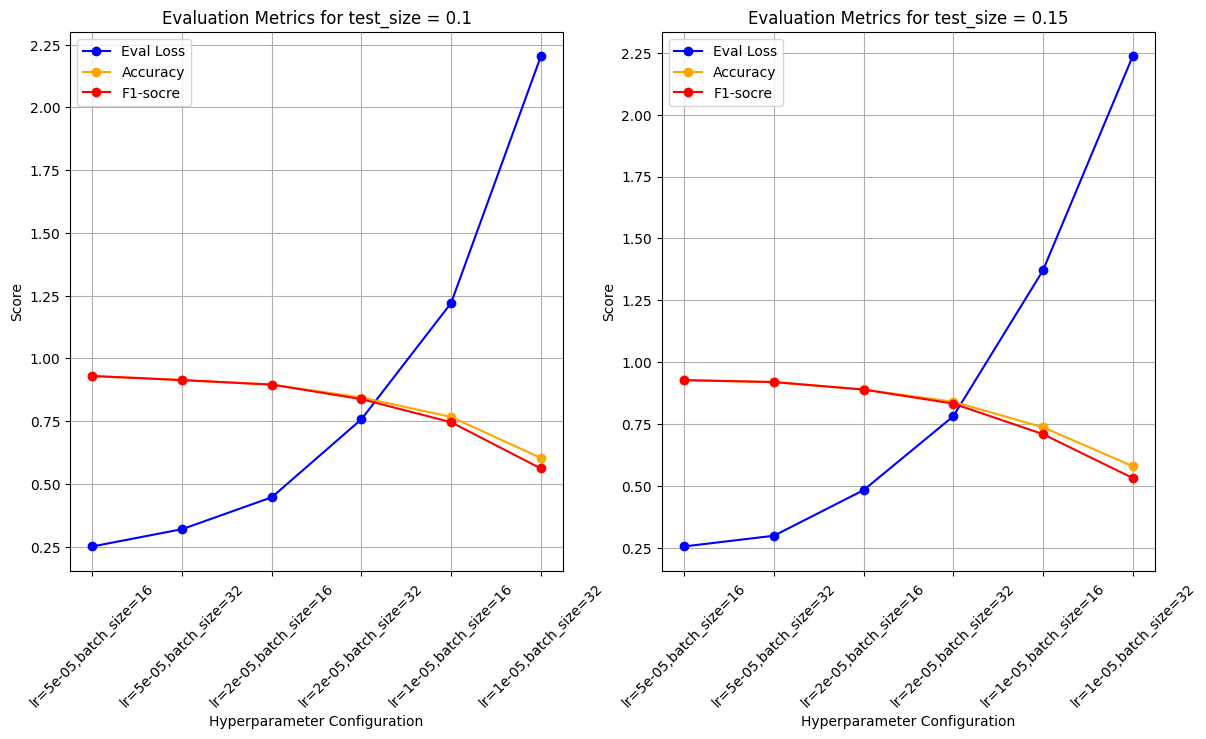

In [51]:
# 提取前六列（col1~col6）
cols1_to_6 = data_test.loc[['eval_loss', 'eval_f1','eval_accuracy'], '5e-05_10_16_0.1':'1e-05_10_32_0.1']

# 提取後六列（col7~col12）
cols7_to_12 = data_test.loc[['eval_loss', 'eval_f1','eval_accuracy'], '5e-05_10_16_0.15':'1e-05_10_32_0.15']

# 繪製圖表：eval_loss 和 eval_f1 for col1~col6
plt.figure(figsize=(14, 7))

cols1_to_6.columns = ['lr=5e-05,batch_size=16',
                       'lr=5e-05,batch_size=32',
                       'lr=2e-05,batch_size=16',
                       'lr=2e-05,batch_size=32',
                       'lr=1e-05,batch_size=16',
                       'lr=1e-05,batch_size=32']

                      

cols7_to_12.columns = ['lr=5e-05,batch_size=16',
                       'lr=5e-05,batch_size=32',
                       'lr=2e-05,batch_size=16',
                       'lr=2e-05,batch_size=32',
                       'lr=1e-05,batch_size=16',
                       'lr=1e-05,batch_size=32']

# 繪製 eval_loss 曲線
plt.subplot(1, 2, 1)
plt.plot(cols1_to_6.columns, cols1_to_6.loc['eval_loss'], marker='o', label='Eval Loss', color='blue')
plt.plot(cols1_to_6.columns, cols1_to_6.loc['eval_accuracy'], marker='o', label='Accuracy', color='orange')
plt.plot(cols1_to_6.columns, cols1_to_6.loc['eval_f1'], marker='o', label='F1-socre', color='red')
plt.title('Evaluation Metrics for test_size = 0.1')
plt.xlabel('Hyperparameter Configuration')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# 繪製圖表：eval_loss 和 eval_f1 for col7~col12
plt.subplot(1, 2, 2)
plt.plot(cols7_to_12.columns, cols7_to_12.loc['eval_loss'], marker='o', label='Eval Loss', color='blue')
plt.plot(cols7_to_12.columns, cols7_to_12.loc['eval_accuracy'], marker='o', label='Accuracy', color='orange')
plt.plot(cols7_to_12.columns, cols7_to_12.loc['eval_f1'], marker='o', label='F1-socre', color='red')
plt.title('Evaluation Metrics for test_size = 0.15')
plt.xlabel('Hyperparameter Configuration')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Hyperparameter fine-tuning

## LoRA fine-tuning

### trainer1 (Lora + lr=1e-04)

In [11]:
model_id = "FacebookAI/roberta-large"  # For tokenize and modeling

train_test_split = tokenized_datasets["train"].shuffle(seed=777).train_test_split(
    test_size=0.1,  
    # stratify_by_column='label',  
    seed=777  
)
train_dataset, valid_dataset = train_test_split["train"], train_test_split["test"]
test_dataset = tokenized_datasets["test"].shuffle(seed=777) 
   

training_args = TrainingArguments(
    output_dir='./result-roberta-lora',
    logging_dir='./logs',
    learning_rate=1e-04,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    
    warmup_steps=500,
    evaluation_strategy="epoch",
    save_strategy="epoch", 
    logging_steps=200,
    weight_decay=0.01,
    load_best_model_at_end=True, 
    metric_for_best_model="accuracy",
    save_total_limit=3,
)   


check_label_proportions(tokenized_datasets["train"], train_dataset, labels_to_check)

ps_model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=77)

# Define the LoRA Configuration
lora_config = LoraConfig(
    r=8, 
    lora_alpha=32, 
    lora_dropout=0.05, 
    target_modules=["query", "key", "value"], 
    bias='none',
    task_type=TaskType.SEQ_CLS 
)

# Get our LoRA-enabled model
peft_model = get_peft_model(ps_model, lora_config)

# 計算參數總數和可訓練參數數量
total_params = sum(p.numel() for p in peft_model.parameters())
trainable_params = sum(p.numel() for p in peft_model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_dataset,  
    eval_dataset=valid_dataset,  
    compute_metrics=compute_metrics,
)

trainer.train()

/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Label 23: 31/35 = 0.89
Label 72: 37/41 = 0.90
Label 10: 54/59 = 0.92
Label 18: 54/61 = 0.89


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Total parameters: 357746842
Trainable parameters: 2308173


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.859800,0.506675,0.862138,0.857025
2,0.423300,0.299524,0.917083,0.916725
3,0.244100,0.268991,0.929071,0.929506
4,0.233900,0.258724,0.931069,0.931106
5,0.186100,0.266992,0.936064,0.936584
6,0.144400,0.276657,0.937063,0.937693
7,0.133200,0.267325,0.938062,0.938519
8,0.109800,0.283012,0.939061,0.939656
9,0.100800,0.288482,0.939061,0.939646
10,0.085400,0.287131,0.939061,0.939521


TrainOutput(global_step=11260, training_loss=0.4149257006060802, metrics={'train_runtime': 835.2205, 'train_samples_per_second': 107.78, 'train_steps_per_second': 13.481, 'total_flos': 1.056900324189696e+16, 'train_loss': 0.4149257006060802, 'epoch': 10.0})

In [12]:
trainer.evaluate(test_dataset)

{'eval_loss': 0.25562918186187744,
 'eval_accuracy': 0.939935064935065,
 'eval_f1': 0.9397031615887951,
 'eval_runtime': 9.4116,
 'eval_samples_per_second': 327.255,
 'eval_steps_per_second': 10.306,
 'epoch': 10.0}

### trainer2 (Lora + lr=1e-04 + test_size=0.15)

In [13]:
model_id = "FacebookAI/roberta-large"  # For tokenize and modeling

train_test_split = tokenized_datasets["train"].shuffle(seed=777).train_test_split(
    test_size=0.15,  
    stratify_by_column='label',  
    seed=777  
)
train_dataset, valid_dataset = train_test_split["train"], train_test_split["test"]
test_dataset = tokenized_datasets["test"].shuffle(seed=777) 
   

training_args = TrainingArguments(
    output_dir='./result-roberta-lora',
    logging_dir='./logs',
    learning_rate=1e-04,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    
    warmup_steps=500,
    evaluation_strategy="epoch",
    save_strategy="epoch", 
    logging_steps=200,
    weight_decay=0.01,
    load_best_model_at_end=True, 
    metric_for_best_model="accuracy",
    save_total_limit=3,
)   


check_label_proportions(tokenized_datasets["train"], train_dataset, labels_to_check)

ps_model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=77)

# Define the LoRA Configuration
lora_config = LoraConfig(
    r=8, 
    lora_alpha=32, 
    lora_dropout=0.05, 
    target_modules=["query", "key", "value"], 
    bias='none',
    task_type=TaskType.SEQ_CLS 
)

# Get our LoRA-enabled model
peft_model = get_peft_model(ps_model, lora_config)

# 計算參數總數和可訓練參數數量
total_params = sum(p.numel() for p in peft_model.parameters())
trainable_params = sum(p.numel() for p in peft_model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

trainer2 = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_dataset,  
    eval_dataset=valid_dataset,  
    compute_metrics=compute_metrics,
)

trainer2.train()

/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Label 23: 30/35 = 0.86
Label 72: 35/41 = 0.85
Label 10: 50/59 = 0.85
Label 18: 52/61 = 0.85


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Total parameters: 357746842
Trainable parameters: 2308173


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.792800,0.517152,0.857428,0.855177
2,0.349600,0.321174,0.914724,0.914637
3,0.278300,0.284991,0.929380,0.929652
4,0.241500,0.299331,0.926049,0.926377
5,0.165700,0.292680,0.928714,0.929208
6,0.152500,0.298760,0.930047,0.930717
7,0.125600,0.296748,0.926716,0.927275
8,0.103400,0.305572,0.928714,0.929206
9,0.087200,0.299694,0.934710,0.935036
10,0.082100,0.299693,0.932045,0.932542


TrainOutput(global_step=10630, training_loss=0.42347611604943547, metrics={'train_runtime': 805.453, 'train_samples_per_second': 105.556, 'train_steps_per_second': 13.198, 'total_flos': 9981966847656960.0, 'train_loss': 0.42347611604943547, 'epoch': 10.0})

In [14]:
trainer2.evaluate(test_dataset)

{'eval_loss': 0.26482194662094116,
 'eval_accuracy': 0.9396103896103896,
 'eval_f1': 0.9395527629462758,
 'eval_runtime': 9.0985,
 'eval_samples_per_second': 338.518,
 'eval_steps_per_second': 10.661,
 'epoch': 10.0}

### trainer11 (Lora + lr=2e-04)

In [50]:
model_id = "FacebookAI/roberta-large"  # For tokenize and modeling

train_test_split = tokenized_datasets["train"].shuffle(seed=777).train_test_split(
    test_size=0.1,  
    # stratify_by_column='label',  
    seed=777  
)
train_dataset, valid_dataset = train_test_split["train"], train_test_split["test"]
test_dataset = tokenized_datasets["test"].shuffle(seed=777) 
   

training_args = TrainingArguments(
    output_dir='./result-roberta-lora',
    logging_dir='./logs',
    learning_rate=2e-04,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    
    warmup_steps=500,
    evaluation_strategy="epoch",
    save_strategy="epoch", 
    logging_steps=200,
    weight_decay=0.01,
    load_best_model_at_end=True, 
    metric_for_best_model="accuracy",
    save_total_limit=3,
)   


check_label_proportions(tokenized_datasets["train"], train_dataset, labels_to_check)

ps_model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=77)

# Define the LoRA Configuration
lora_config = LoraConfig(
    r=8, 
    lora_alpha=32, 
    lora_dropout=0.05, 
    target_modules=["query", "key", "value"], 
    bias='none',
    task_type=TaskType.SEQ_CLS 
)

# Get our LoRA-enabled model
peft_model = get_peft_model(ps_model, lora_config)

# 計算參數總數和可訓練參數數量
total_params = sum(p.numel() for p in peft_model.parameters())
trainable_params = sum(p.numel() for p in peft_model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

trainer11 = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_dataset,  
    eval_dataset=valid_dataset,  
    compute_metrics=compute_metrics,
)

trainer11.train()

/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Label 23: 31/35 = 0.89
Label 72: 37/41 = 0.90
Label 10: 54/59 = 0.92
Label 18: 54/61 = 0.89


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Total parameters: 357746842
Trainable parameters: 2308173


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.634900,0.414787,0.885115,0.884822
2,0.386700,0.311139,0.915085,0.915286
3,0.216100,0.293739,0.928072,0.928612
4,0.226300,0.316139,0.927073,0.927429
5,0.178000,0.317576,0.933067,0.933681
6,0.123700,0.336439,0.933067,0.934027
7,0.098800,0.335588,0.932068,0.932572
8,0.073600,0.344200,0.935065,0.935660
9,0.050600,0.347191,0.935065,0.935637
10,0.036000,0.351859,0.934066,0.934735


TrainOutput(global_step=11260, training_loss=0.34479335610015355, metrics={'train_runtime': 842.2036, 'train_samples_per_second': 106.886, 'train_steps_per_second': 13.37, 'total_flos': 1.056900324189696e+16, 'train_loss': 0.34479335610015355, 'epoch': 10.0})

In [58]:
trainer11.evaluate(test_dataset)

{'eval_loss': 0.29578691720962524,
 'eval_accuracy': 0.9396103896103896,
 'eval_f1': 0.9396108521577248,
 'eval_runtime': 9.2395,
 'eval_samples_per_second': 333.352,
 'eval_steps_per_second': 10.498,
 'epoch': 10.0}

## Full parameter fine-tuning

### trainer3 (lr=2e-05)

In [17]:
model_id = "FacebookAI/roberta-large"  # For tokenize and modeling

train_test_split = tokenized_datasets["train"].shuffle(seed=777).train_test_split(
    test_size=0.1,  
    stratify_by_column='label',  
    seed=777  
)
train_dataset, valid_dataset = train_test_split["train"], train_test_split["test"]
test_dataset = tokenized_datasets["test"].shuffle(seed=777) 
   

training_args = TrainingArguments(
    output_dir='./result-roberta-lora',
    logging_dir='./logs',
    learning_rate=2e-05,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    
    warmup_steps=500,
    evaluation_strategy="epoch",
    save_strategy="epoch", 
    logging_steps=200,
    weight_decay=0.01,
    load_best_model_at_end=True, 
    metric_for_best_model="accuracy",
    save_total_limit=3,
)   


check_label_proportions(tokenized_datasets["train"], train_dataset, labels_to_check)

ps_model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=77)

# # Define the LoRA Configuration
# lora_config = LoraConfig(
#     r=8, 
#     lora_alpha=32, 
#     lora_dropout=0.05, 
#     target_modules=["query", "key", "value"], 
#     bias='none',
#     task_type=TaskType.SEQ_CLS 
# )

# # Get our LoRA-enabled model
# peft_model = get_peft_model(ps_model, lora_config)

# 計算參數總數和可訓練參數數量
total_params = sum(p.numel() for p in ps_model.parameters())
trainable_params = sum(p.numel() for p in ps_model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

trainer3 = Trainer(
    model=ps_model,
    args=training_args,
    train_dataset=train_dataset,  
    eval_dataset=valid_dataset,  
    compute_metrics=compute_metrics,
)

trainer3.train()

/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Label 23: 32/35 = 0.91
Label 72: 37/41 = 0.90
Label 10: 53/59 = 0.90
Label 18: 55/61 = 0.90


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Total parameters: 355438669
Trainable parameters: 355438669


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.678100,0.443409,0.888112,0.883336
2,0.309900,0.384600,0.913087,0.912765
3,0.207600,0.427928,0.926074,0.926123
4,0.169100,0.395248,0.931069,0.930921
5,0.095700,0.431252,0.936064,0.936163
6,0.090500,0.425523,0.938062,0.938126
7,0.057000,0.480606,0.936064,0.936240
8,0.018700,0.466968,0.938062,0.938325
9,0.010800,0.472549,0.941059,0.941059
10,0.008500,0.471182,0.942058,0.942175


TrainOutput(global_step=11260, training_loss=0.3266562417546555, metrics={'train_runtime': 1563.7872, 'train_samples_per_second': 57.565, 'train_steps_per_second': 7.2, 'total_flos': 1.048921505624832e+16, 'train_loss': 0.3266562417546555, 'epoch': 10.0})

In [18]:
trainer3.evaluate(test_dataset)

{'eval_loss': 0.43707409501075745,
 'eval_accuracy': 0.9431818181818182,
 'eval_f1': 0.9430739247047071,
 'eval_runtime': 8.5345,
 'eval_samples_per_second': 360.889,
 'eval_steps_per_second': 11.366,
 'epoch': 10.0}

### trainer4 (lr=1e-05)

In [19]:
model_id = "FacebookAI/roberta-large"  # For tokenize and modeling

train_test_split = tokenized_datasets["train"].shuffle(seed=777).train_test_split(
    test_size=0.1,  
    stratify_by_column='label',  
    seed=777  
)
train_dataset, valid_dataset = train_test_split["train"], train_test_split["test"]
test_dataset = tokenized_datasets["test"].shuffle(seed=777) 
   

training_args = TrainingArguments(
    output_dir='./result-roberta-lora',
    logging_dir='./logs',
    learning_rate=1e-05,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    
    warmup_steps=500,
    evaluation_strategy="epoch",
    save_strategy="epoch", 
    logging_steps=200,
    weight_decay=0.01,
    load_best_model_at_end=True, 
    metric_for_best_model="accuracy",
    save_total_limit=3,
)   


check_label_proportions(tokenized_datasets["train"], train_dataset, labels_to_check)

ps_model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=77)

# # Define the LoRA Configuration
# lora_config = LoraConfig(
#     r=8, 
#     lora_alpha=32, 
#     lora_dropout=0.05, 
#     target_modules=["query", "key", "value"], 
#     bias='none',
#     task_type=TaskType.SEQ_CLS 
# )

# # Get our LoRA-enabled model
# peft_model = get_peft_model(ps_model, lora_config)

# 計算參數總數和可訓練參數數量
total_params = sum(p.numel() for p in ps_model.parameters())
trainable_params = sum(p.numel() for p in ps_model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

trainer4 = Trainer(
    model=ps_model,
    args=training_args,
    train_dataset=train_dataset,  
    eval_dataset=valid_dataset,  
    compute_metrics=compute_metrics,
)

trainer4.train()

/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Label 23: 32/35 = 0.91
Label 72: 37/41 = 0.90
Label 10: 53/59 = 0.90
Label 18: 55/61 = 0.90


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Total parameters: 355438669
Trainable parameters: 355438669


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.163200,0.599167,0.881119,0.879765
2,0.346000,0.298604,0.929071,0.929453
3,0.212400,0.359657,0.932068,0.932687
4,0.169500,0.352689,0.935065,0.934904
5,0.119600,0.365377,0.940060,0.940124
6,0.091100,0.365052,0.939061,0.939106
7,0.039300,0.387786,0.941059,0.941277
8,0.021900,0.405963,0.937063,0.937288
9,0.017300,0.413378,0.938062,0.938120
10,0.008900,0.417792,0.942058,0.942022


TrainOutput(global_step=11260, training_loss=0.3947815069508595, metrics={'train_runtime': 1549.7282, 'train_samples_per_second': 58.088, 'train_steps_per_second': 7.266, 'total_flos': 1.048921505624832e+16, 'train_loss': 0.3947815069508595, 'epoch': 10.0})

In [20]:
trainer4.evaluate(test_dataset)

{'eval_loss': 0.42635011672973633,
 'eval_accuracy': 0.9412337662337662,
 'eval_f1': 0.9410891322510619,
 'eval_runtime': 8.6182,
 'eval_samples_per_second': 357.384,
 'eval_steps_per_second': 11.255,
 'epoch': 10.0}

## Best_result

In [56]:
model_id = "FacebookAI/roberta-large"  # For tokenize and modeling

train_test_split = tokenized_datasets["train"].shuffle(seed=777).train_test_split(
    test_size=0.1,  
    stratify_by_column='label',  
    seed=777  
)
train_dataset, valid_dataset = train_test_split["train"], train_test_split["test"]
test_dataset = tokenized_datasets["test"].shuffle(seed=777) 
   

training_args = TrainingArguments(
    output_dir='./final_result',
    logging_dir='./logs',
    learning_rate=2e-05,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    
    warmup_steps=500,
    evaluation_strategy="epoch",
    save_strategy="epoch", 
    logging_steps=200,
    weight_decay=0.01,
    load_best_model_at_end=True, 
    metric_for_best_model="accuracy",
    save_total_limit=3,
)   


check_label_proportions(tokenized_datasets["train"], train_dataset, labels_to_check)

ps_model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=77)

# # Define the LoRA Configuration
# lora_config = LoraConfig(
#     r=8, 
#     lora_alpha=32, 
#     lora_dropout=0.05, 
#     target_modules=["query", "key", "value"], 
#     bias='none',
#     task_type=TaskType.SEQ_CLS 
# )

# # Get our LoRA-enabled model
# peft_model = get_peft_model(ps_model, lora_config)

# 計算參數總數和可訓練參數數量
total_params = sum(p.numel() for p in ps_model.parameters())
trainable_params = sum(p.numel() for p in ps_model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

trainer6 = Trainer(
    model=ps_model,
    args=training_args,
    train_dataset=train_dataset,  
    eval_dataset=valid_dataset,  
    compute_metrics=compute_metrics,
)

trainer6.train()

/home/dykos0508/.virtualenvs/torch_s/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Label 23: 32/35 = 0.91
Label 72: 37/41 = 0.90
Label 10: 53/59 = 0.90
Label 18: 55/61 = 0.90


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Total parameters: 355438669
Trainable parameters: 355438669


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.678100,0.443409,0.888112,0.883336
2,0.309900,0.384600,0.913087,0.912765
3,0.207600,0.427928,0.926074,0.926123
4,0.169100,0.395248,0.931069,0.930921
5,0.095700,0.431252,0.936064,0.936163
6,0.090500,0.425523,0.938062,0.938126
7,0.057000,0.480606,0.936064,0.936240
8,0.018700,0.466968,0.938062,0.938325
9,0.010800,0.472549,0.941059,0.941059
10,0.008500,0.471182,0.942058,0.942175


TrainOutput(global_step=11260, training_loss=0.3266562417546555, metrics={'train_runtime': 1502.8711, 'train_samples_per_second': 59.899, 'train_steps_per_second': 7.492, 'total_flos': 1.048921505624832e+16, 'train_loss': 0.3266562417546555, 'epoch': 10.0})

In [57]:
trainer6.evaluate(test_dataset)

{'eval_loss': 0.43707409501075745,
 'eval_accuracy': 0.9431818181818182,
 'eval_f1': 0.9430739247047071,
 'eval_runtime': 8.5831,
 'eval_samples_per_second': 358.845,
 'eval_steps_per_second': 11.301,
 'epoch': 10.0}

In [59]:
training_args

TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=epoch,
eval_use_gather_object=False,
evaluation_strategy=epoch,
fp

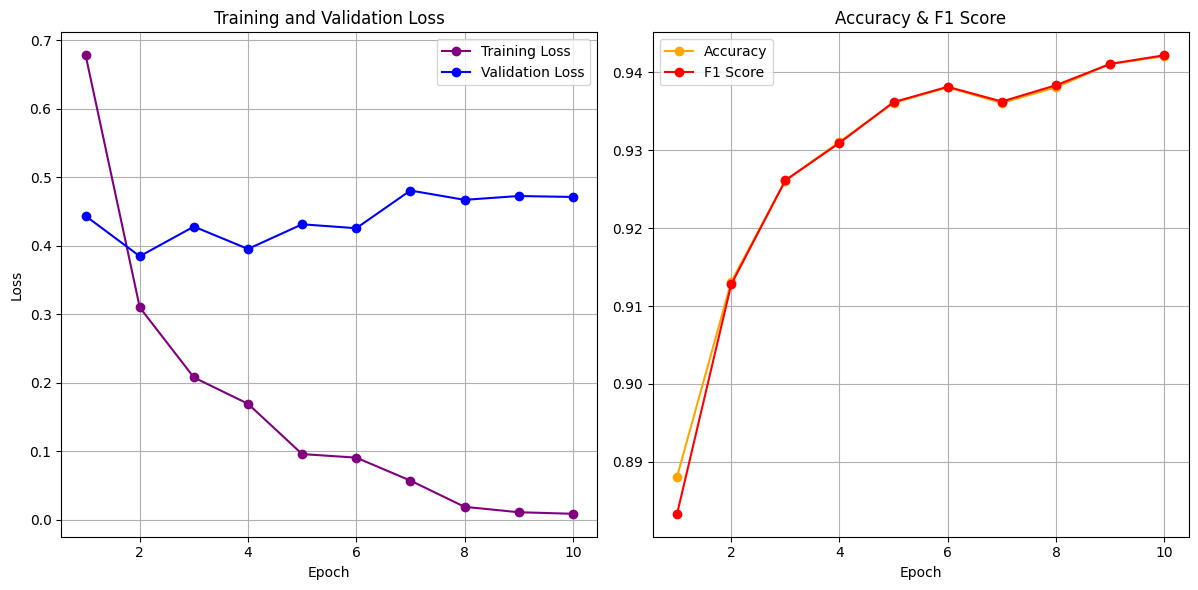

In [13]:
data = {
    "Epoch": list(range(1, 11)),
    "Training Loss": [0.678100, 0.309900, 0.207600, 0.169100, 0.095700, 0.090500, 0.057000, 0.018700, 0.010800, 0.008500],
    "Validation Loss": [0.443409, 0.384600, 0.427928, 0.395248, 0.431252, 0.425523, 0.480606, 0.466968, 0.472549, 0.471182],
    "Accuracy": [0.888112, 0.913087, 0.926074, 0.931069, 0.936064, 0.938062, 0.936064, 0.938062, 0.941059, 0.942058],
    "F1": [0.883336, 0.912765, 0.926123, 0.930921, 0.936163, 0.938126, 0.936240, 0.938325, 0.941059, 0.942175]
}

df = pd.DataFrame(data)
plt.figure(figsize=(18, 6))

# 繪製 Training Loss 和 Validation Loss
plt.subplot(1, 3, 1)
plt.plot(df["Epoch"], df["Training Loss"], marker='o', label='Training Loss', color='purple')
plt.plot(df["Epoch"], df["Validation Loss"], marker='o', label='Validation Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# 繪製 Accuracy
plt.subplot(1, 3, 2)
plt.plot(df["Epoch"], df["Accuracy"], marker='o',label='Accuracy', color='orange')
plt.plot(df["Epoch"], df["F1"], marker='o', label='F1 Score', color='red')
plt.xlabel('Epoch')
plt.title('Accuracy & F1 Score')
plt.legend()
plt.grid(True)

# 顯示圖形
plt.tight_layout()
plt.show()

# 錯誤分析

In [75]:
lable_mapping_dict = {index:l for index,l in enumerate(dataset['train'].features['label'].names)}

In [76]:
# Step 1: 使用 predict() 方法來獲取模型的預測結果
predictions = trainer6.predict(test_dataset)

# Step 2: 提取預測的標籤和實際的標籤
predicted_labels = np.argmax(predictions.predictions, axis=1)  # 取出預測的標籤
actual_labels = test_dataset['label']  # 實際標籤

# Step 3: 找出分類錯誤的索引
misclassified_indices = np.where(predicted_labels != actual_labels)[0]

# Step 4: 根據索引提取分類錯誤的數據
misclassified_samples = test_dataset.select(misclassified_indices)

# Step 5: 將分類錯誤的樣本轉換為 DataFrame
misclassified_df = misclassified_samples.to_pandas()

# Step 6: 提取錯誤分類的預測標籤，並添加到 DataFrame 作為新的一列 pred_label
misclassified_df['pred_label'] = predicted_labels[misclassified_indices]
misclassified_df = misclassified_df.loc[:, ['text', 'label', 'pred_label']]

misclassified_df['label_mapping'] = misclassified_df['label'].apply(lambda x: lable_mapping_dict[x])
misclassified_df['pred_label_mapping'] = misclassified_df['pred_label'].apply(lambda x: lable_mapping_dict[x])

In [70]:
misclassified_df

,text,label,pred_label,label_mapping,pred_label_mapping
0,Can you freeze my card because someone used it...,22,16,compromised_card,card_payment_not_recognised
1,I made a transfer and am still waiting.,5,48,balance_not_updated_after_bank_transfer,pending_transfer
2,How do I know when my card will arrive?,11,12,card_arrival,card_delivery_estimate
3,Can I get my card expedited?,12,11,card_delivery_estimate,card_arrival
4,How long does it take for a transfer?,67,5,transfer_timing,balance_not_updated_after_bank_transfer
...,...,...,...,...,...
170,Can you help with a transfer to an account,7,65,beneficiary_not_allowed,transfer_into_account
171,How long does it take for an international tra...,5,67,balance_not_updated_after_bank_transfer,transfer_timing
172,My ATM got stuck and I'm not sure what to do.,18,26,card_swallowed,declined_cash_withdrawal
173,Is a copy of the police report necessary for c...,41,69,lost_or_stolen_card,verify_my_identity


In [77]:
misclassified_df.to_csv('misclass_df.csv',encoding='utf-8-sig')